# Домашнее задание Внедрение моделей ML

Выполнил: Груданов Николай Алексеевич

## Exploratory Data Analysis

In [1]:
!python --version

Python 3.13.2


In [2]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy
from scipy.stats import norm, shapiro, ks_2samp, kstest, mannwhitneyu, ttest_ind
import statsmodels
import statsmodels.stats.proportion as smp
import math

print(f' pandas version: {pd.__version__}')
print(f' numpy version: {np.__version__}')
print(f' seaborn version: {sns.__version__}')
print(f' matplotlib version: {matplotlib.__version__}')
print(f' scipy version: {scipy.__version__}')
print(f' statsmodels version: {statsmodels.__version__}')

 pandas version: 2.2.3
 numpy version: 2.2.5
 seaborn version: 0.13.2
 matplotlib version: 3.10.1
 scipy version: 1.15.2
 statsmodels version: 0.14.4


In [3]:
df = pd.read_csv('AB-tests_HW/marketing_AB.csv')


In [4]:
def df_info(df:pd.DataFrame)-> None:
    """
    Функция df_info выводит информацию о DataFrame.
    Args:
       df (pandas.DataFrame): DataFrame, для которого выводится информация.

    Returns:
       None: Функция не возвращает никакого значения, она только выводит информацию.
    """
    print("Названия столбцов")
    print(df.columns) 
    print("-----------------------------------------------------------------------------------------")
    print("Описание столбцов")
    print(df.info()) 
    print("-----------------------------------------------------------------------------------------")
    print("Статистические данные")
    # Форматируем результат describe() до двух знаков после запятой
    formatted = df.describe().apply(lambda x: x.apply('{:.2f}'.format))
    print(formatted)
    print("-----------------------------------------------------------------------------------------")
    print("Проверка на null значений")
    print(df.isnull().sum()) 

In [5]:
df_info(df)

Названия столбцов
Index(['Unnamed: 0', 'user id', 'test group', 'converted', 'total ads',
       'most ads day', 'most ads hour'],
      dtype='object')
-----------------------------------------------------------------------------------------
Описание столбцов
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 588101 entries, 0 to 588100
Data columns (total 7 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   Unnamed: 0     588101 non-null  int64 
 1   user id        588101 non-null  int64 
 2   test group     588101 non-null  object
 3   converted      588101 non-null  bool  
 4   total ads      588101 non-null  int64 
 5   most ads day   588101 non-null  object
 6   most ads hour  588101 non-null  int64 
dtypes: bool(1), int64(4), object(2)
memory usage: 27.5+ MB
None
-----------------------------------------------------------------------------------------
Статистические данные
      Unnamed: 0     user id  total ads most ads hour
co

В предоставленных данных отсутствуют пропуски.

In [6]:
# Посмотрим первые 5 строк датафрейма 
display(df.head())

,Unnamed: 0,user id,test group,converted,total ads,most ads day,most ads hour
0,0,1069124,ad,False,130,Monday,20
1,1,1119715,ad,False,93,Tuesday,22
2,2,1144181,ad,False,21,Tuesday,18
3,3,1435133,ad,False,355,Tuesday,10
4,4,1015700,ad,False,276,Friday,14


In [7]:
display(df['most ads day'].value_counts())

most ads day
Friday       92608
Monday       87073
Sunday       85391
Thursday     82982
Saturday     81660
Wednesday    80908
Tuesday      77479
Name: count, dtype: int64

In [8]:
display(df['converted'].value_counts())

converted
False    573258
True      14843
Name: count, dtype: int64

In [9]:
display(df['test group'].value_counts())

test group
ad     564577
psa     23524
Name: count, dtype: int64

Анализ данных выявил, что определенная часть информации имеет категориальную природу. В связи с этим целесообразно выполнить преобразование соответствующих признаков в категориальный формат данных.

In [10]:
df['test group'] = df['test group'].astype('category')
df['most ads day'] = df['most ads day'].astype('category')
df['converted'] = df['converted'].astype(int)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 588101 entries, 0 to 588100
Data columns (total 7 columns):
 #   Column         Non-Null Count   Dtype   
---  ------         --------------   -----   
 0   Unnamed: 0     588101 non-null  int64   
 1   user id        588101 non-null  int64   
 2   test group     588101 non-null  category
 3   converted      588101 non-null  int64   
 4   total ads      588101 non-null  int64   
 5   most ads day   588101 non-null  category
 6   most ads hour  588101 non-null  int64   
dtypes: category(2), int64(5)
memory usage: 23.6 MB


In [12]:
df['user id'].value_counts()

user id
1237779    1
1069124    1
1119715    1
1144181    1
1435133    1
          ..
1448851    1
1446284    1
1257223    1
1637531    1
1081965    1
Name: count, Length: 588101, dtype: int64

Видим, что индексная колонка "unamed: 0" не имеет практической значимости, удалим ее, и проверим пропуски

In [13]:
df.drop(columns=['Unnamed: 0'], inplace=True)
print(df.isnull().sum())

user id          0
test group       0
converted        0
total ads        0
most ads day     0
most ads hour    0
dtype: int64


Пропусков нет

In [14]:
print(df['test group'].unique())

['ad', 'psa']
Categories (2, object): ['ad', 'psa']


In [15]:
duplicate_users = df.groupby('user id')['test group'].nunique()
print(len(duplicate_users[duplicate_users > 1]))

0


В тестовой группе участники делятся на две категории.
Также можно заметить, что эти две группы не пересекаются.

## Статистический анализ результатов A/B-тестирования

Создадим два набора данных и проведем количественный анализ, направленный на определение численности пользователей в каждом из них.

In [16]:
group_ad = df[df['test group'] == 'ad']
group_psa = df[df['test group'] == 'psa']

In [17]:
print(f"Общее количество записей в данных: {len(df)}")
print("-----------------------------------------------------------------------------------------")
print("Распределение по группам:")
print(df['test group'].value_counts())


Общее количество записей в данных: 588101
-----------------------------------------------------------------------------------------
Распределение по группам:
test group
ad     564577
psa     23524
Name: count, dtype: int64


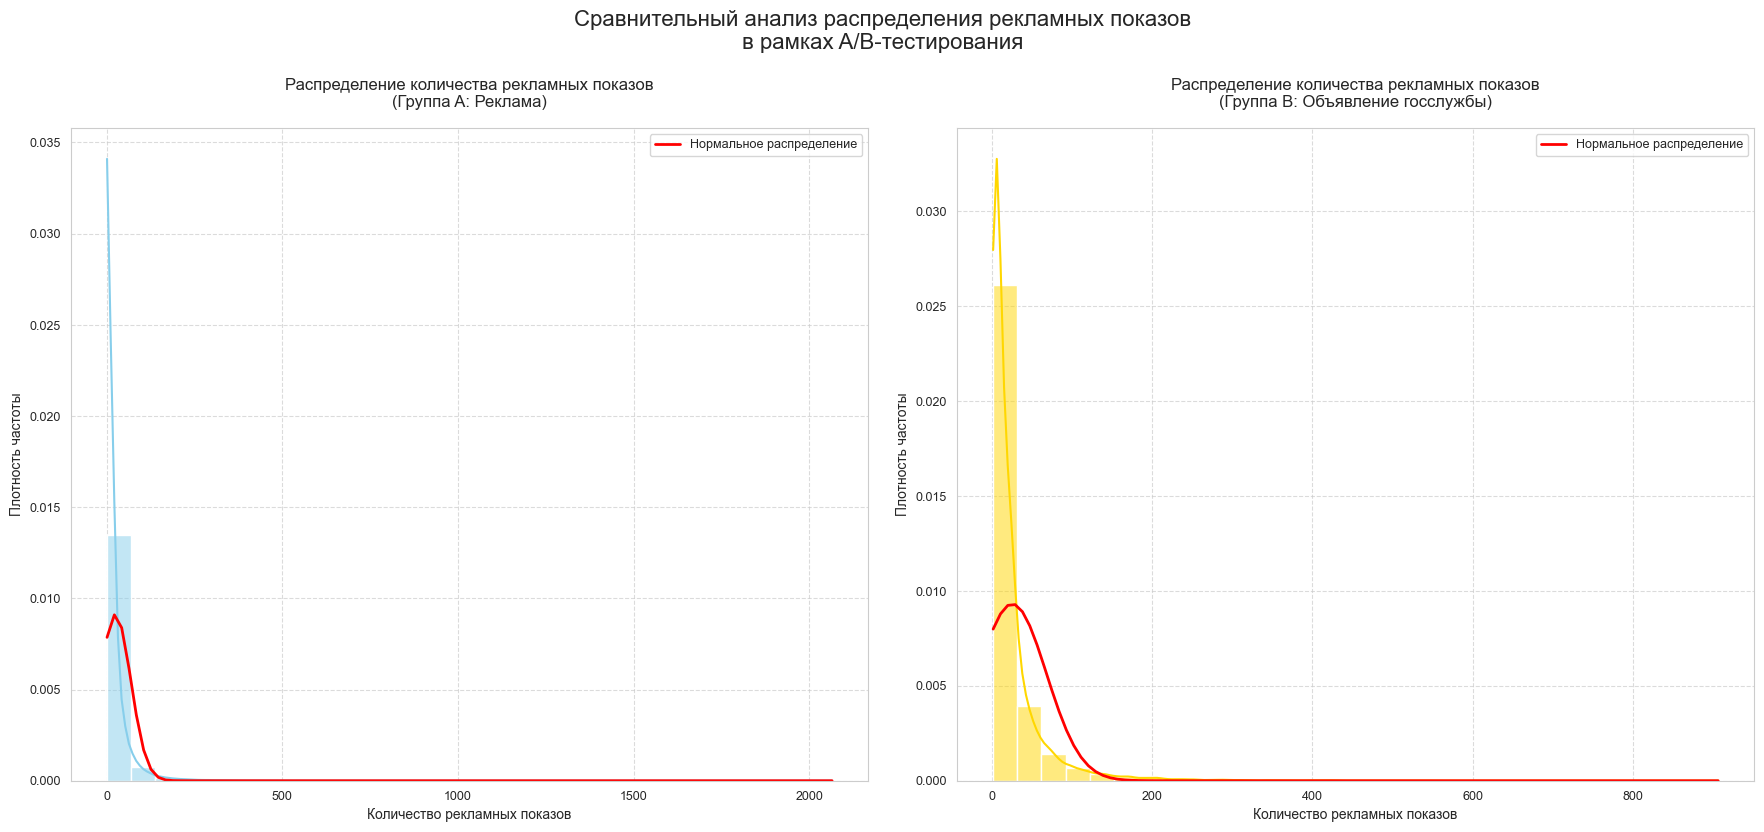

In [18]:
# Настройка стиля визуализации
sns.set_style('whitegrid')

# Создание фигуры с двумя подграфиками для сравнения распределений
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 8), dpi=100)

# Данные для групп 
ad_data = group_ad['total ads']
psa_data = group_psa['total ads']

# Гистограмма и KDE для группы A (ad - тестовая группа)
sns.histplot(ad_data, bins=30, kde=True, color='skyblue', stat='density', ax=axes[0])
axes[0].set_title('Распределение количества рекламных показов\n(Группа A: Реклама)', fontsize=12, pad=15)
axes[0].set_xlabel('Количество рекламных показов', fontsize=10)
axes[0].set_ylabel('Плотность частоты', fontsize=10)
axes[0].grid(True, linestyle='--', alpha=0.7)  # Добавляем сетку для лучшей читаемости
axes[0].tick_params(axis='both', which='major', labelsize=9)

# Добавление теоретической нормальной кривой для сравнения
mu_ad, sigma_ad = np.mean(ad_data), np.std(ad_data)
x_ad = np.linspace(min(ad_data), max(ad_data), 100)
axes[0].plot(x_ad, norm.pdf(x_ad, mu_ad, sigma_ad), 'r-', lw=2, label='Нормальное распределение')
axes[0].legend(fontsize=9)

# Гистограмма и KDE для группы B (psa - контрольная группа)
sns.histplot(psa_data, bins=30, kde=True, color='gold', stat='density', ax=axes[1])
axes[1].set_title('Распределение количества рекламных показов\n(Группа B: Объявление госслужбы)', fontsize=12, pad=15)
axes[1].set_xlabel('Количество рекламных показов', fontsize=10)
axes[1].set_ylabel('Плотность частоты', fontsize=10)
axes[1].grid(True, linestyle='--', alpha=0.7)  # Добавляем сетку для лучшей читаемости
axes[1].tick_params(axis='both', which='major', labelsize=9)

# Добавление теоретической нормальной кривой для сравнения
mu_psa, sigma_psa = np.mean(psa_data), np.std(psa_data)
x_psa = np.linspace(min(psa_data), max(psa_data), 100)
axes[1].plot(x_psa, norm.pdf(x_psa, mu_psa, sigma_psa), 'r-', lw=2, label='Нормальное распределение')
axes[1].legend(fontsize=9)

# Настройка компоновки для предотвращения наложения элементов
plt.tight_layout(pad=2.0)

# Добавление общего заголовка для всей фигуры
fig.suptitle('Сравнительный анализ распределения рекламных показов\nв рамках A/B-тестирования', fontsize=16, y=1.05)

# Отображение графика
plt.show()


Анализ данных с помощью графиков показывает, что количество показов рекламы в обеих группах не соответствует стандартному распределению. 

In [19]:
# Выбираем данные для теста Шапиро-Уилка
ad_data = df[df['test group'] == 'ad']['total ads']
psa_data = df[df['test group'] == 'psa']['total ads']

# Применяем тест Шапиро-Уилка к данным группы A (ad)
shapiro_test_ad = shapiro(ad_data)
print("Результаты теста Шапиро-Уилка для группы A (ad):")
print(f"Статистика W: {shapiro_test_ad.statistic:.3f}, p-значение: {shapiro_test_ad.pvalue}")

# Применяем тест Шапиро-Уилка к данным группы B (psa)
shapiro_test_psa = shapiro(psa_data)
print("Результаты теста Шапиро-Уилка для группы B (psa):")
print(f"Статистика W: {shapiro_test_psa.statistic:.3f}, p-значение: {shapiro_test_psa.pvalue}")

Результаты теста Шапиро-Уилка для группы A (ad):
Статистика W: 0.479, p-значение: 3.701044472444164e-203
Результаты теста Шапиро-Уилка для группы B (psa):
Статистика W: 0.516, p-значение: 7.270789402370636e-120


/home/gna/anaconda3/envs/ml/lib/python3.13/site-packages/scipy/stats/_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 564577.
  res = hypotest_fun_out(*samples, **kwds)
/home/gna/anaconda3/envs/ml/lib/python3.13/site-packages/scipy/stats/_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 23524.
  res = hypotest_fun_out(*samples, **kwds)


In [20]:
# Применяем одновыборочный тест Колмогорова-Смирнова к данным группы A (ad)
ks_test_ad = kstest(ad_data, 'norm')
print("Результаты теста Колмогорова-Смирнова для группы A (ad):")
print(f"Статистика D: {ks_test_ad.statistic:.3f}, p-значение: {ks_test_ad.pvalue}")

# Применяем одновыборочный тест Колмогорова-Смирнова к данным группы B (psa)
ks_test_psa = kstest(psa_data, 'norm')
print("Результаты теста Колмогорова-Смирнова для группы B (psa):")
print(f"Статистика D: {ks_test_psa.statistic:.3f}, p-значение: {ks_test_psa.pvalue}")

# Применяем двухвыборочный тест Колмогорова-Смирнова для сравнения распределений
ks_test = ks_2samp(group_ad['total ads'], group_psa['total ads'])
print("Результаты двухвыборочного теста Колмогорова-Смирнова для сравнения распределений:")
print(f"Статистика D: = {ks_test.statistic:.3f}, p-value = {ks_test.pvalue}")

Результаты теста Колмогорова-Смирнова для группы A (ad):
Статистика D: 0.881, p-значение: 0.0
Результаты теста Колмогорова-Смирнова для группы B (psa):
Статистика D: 0.879, p-значение: 0.0
Результаты двухвыборочного теста Колмогорова-Смирнова для сравнения распределений:
Статистика D: = 0.040, p-value = 2.3426508802338634e-31


Данные о количестве рекламных показов в группах «ad» и «psa» сильно отклоняются от нормального распределения. Это подтверждено тестом Шапиро-Уилка (p-значения близки к нулю) и одновыборочным тестом Колмогорова-Смирнова (p-значения равны нулю).

Для сравнения двух независимых выборок подходит U-критерий Манна-Уитни, обладающий высокой мощностью и позволяющий делать надёжные выводы о различиях между группами.

In [21]:
stat, p = mannwhitneyu(ad_data, psa_data)
print(f"U-тест Манна-Уитни: stat = {stat}, p-value = {p}")

U-тест Манна-Уитни: stat = 6808288222.0, p-value = 4.6909108547205694e-11


Результаты U-теста Манна-Уитни подтверждают, что количество рекламных показов в группах "ad" и "psa" имеет статистически значимые различия. Это согласуется с результатами двухвыборочного теста Колмогорова-Смирнова

## Формулировка гипотез

- **Нулевая гипотеза (H0)**: статистические показатели конверсии между группами A (реклама) и B (объявление госслужбы) не различаются и не показывают значимых отличий.

- **Альтернативная гипотеза (H1)**: между группами A и B есть существенная разница в показателях конверсии. 

In [22]:
duplicate_users = df.groupby('user id')['test group'].nunique()
print(len(duplicate_users[duplicate_users > 1]))

0


Пересекающихся групп нет

Создадим графики распределения времени на сайте для группы А и Б.

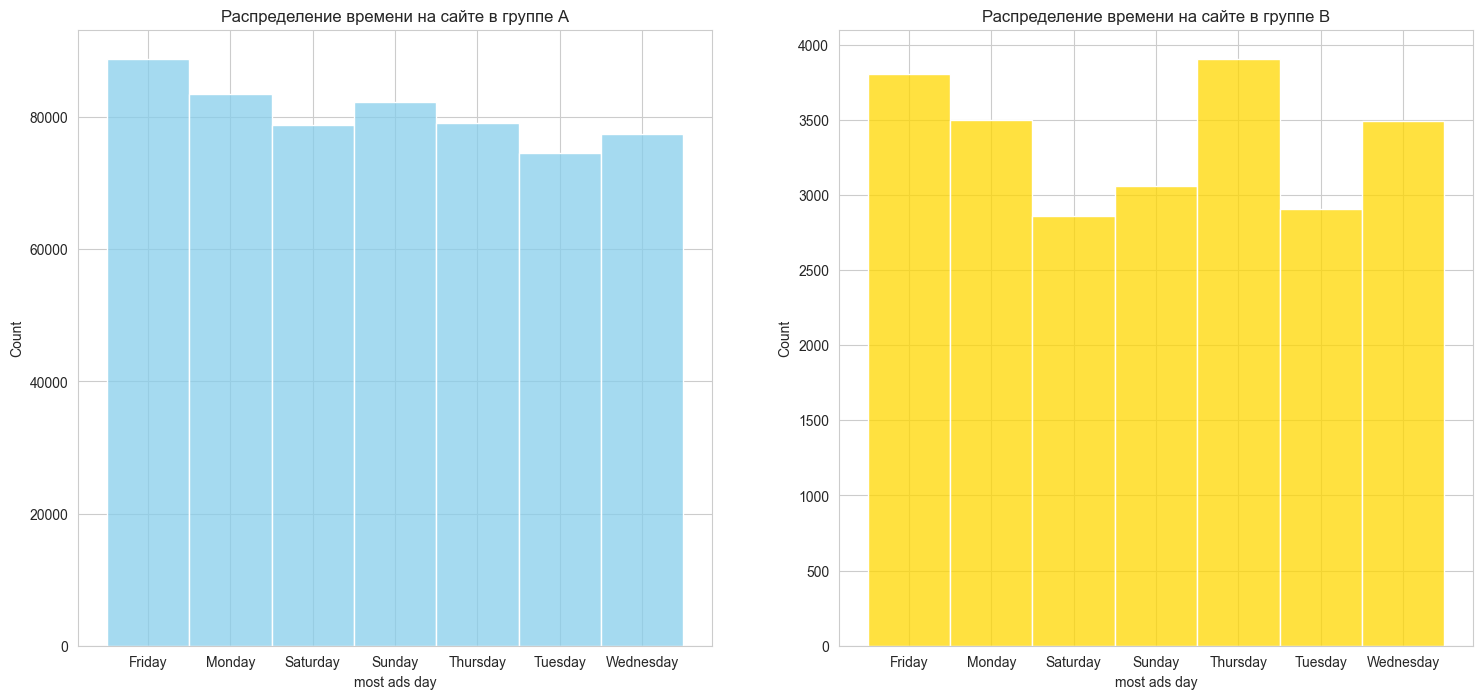

In [23]:
fig, axes = plt.subplots(1, 2, figsize=(18, 8), dpi=100)
sns.histplot(x='most ads day', data=group_ad, ax=axes[0], color='skyblue')
sns.histplot(x='most ads day', data=group_psa, ax=axes[1], color='gold')

axes[0].set_title('Распределение времени на сайте в группе А');
axes[1].set_title('Распределение времени на сайте в группе B');

Подсчёт конверсий и общего числа пользователей в каждой группе

In [24]:
conversion_data = df.groupby('test group', observed=True).agg({
    'converted': ['sum', 'count']
}).rename(columns={'sum': 'conversions', 'count': 'total_users'})

conversion_data.columns = ['conversions', 'total_users']
print(conversion_data)

            conversions  total_users
test group                          
ad                14423       564577
psa                 420        23524


Подсчёт числа пользователей без конверсии

In [25]:
conversion_data['non_conversions'] = conversion_data['total_users'] - conversion_data['conversions']

contingency_table = conversion_data[['conversions', 'non_conversions', 'total_users']]
print(contingency_table)

            conversions  non_conversions  total_users
test group                                           
ad                14423           550154       564577
psa                 420            23104        23524


In [26]:
def calculate_metrics(df: pd.DataFrame)->pd.DataFrame:
   """
   Группирует данные по 'test group' и рассчитывает метрики.

   Args:
       df (pandas.DataFrame): DataFrame с данными.

   Returns:
       pandas.DataFrame: DataFrame с рассчитанными метриками.
   """
   # Группировка данных по 'test group' для расчёта метрик
   grouped = df.groupby('test group', observed=True).agg(
       visits=('user id', 'count'),           # Количество посещений (число пользователей в группе)
       conversions=('converted', 'sum'),      # Количество конверсий (сумма значений в 'converted')
       total_ads=('total ads', 'sum'),        # Общее количество увиденной рекламы
       avg_ads=('total ads', 'mean')          # Среднее количество увиденной рекламы
   )
   # Расчёт конверсии в процентах
   grouped['conversion_rate_percent'] = round((grouped['conversions'] / grouped['visits']) * 100, 2)
   return grouped


# Вызов функции для расчёта метрик
metrics = calculate_metrics(df)
display(metrics)

,visits,conversions,total_ads,avg_ads,conversion_rate_percent
test group,,,,,
ad,564577,14423,14014701,24.823365,2.55
psa,23524,420,582481,24.761138,1.79


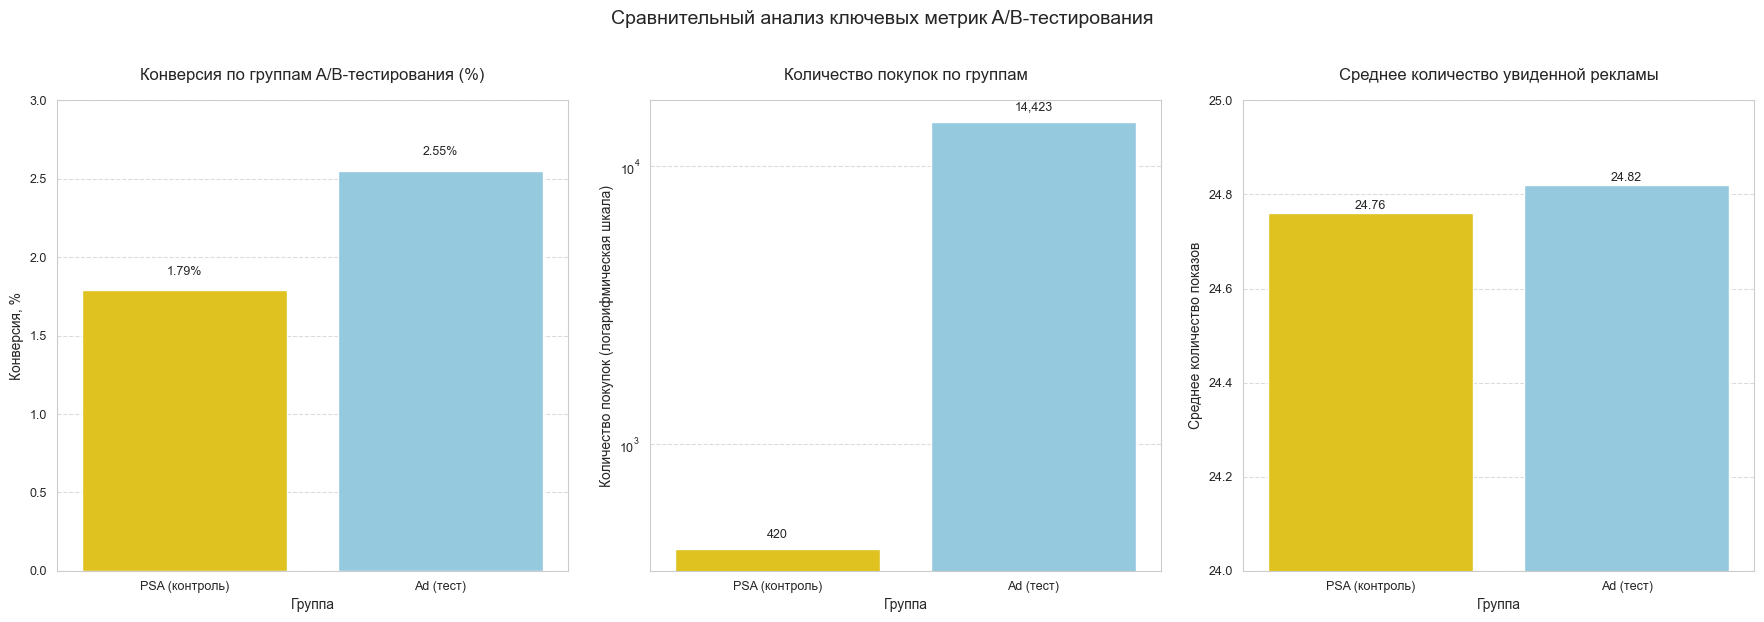

In [27]:
# Данные для визуализации
groups = ['PSA (контроль)', 'Ad (тест)']
conversion_rates = [1.79, 2.55]  # в процентах
purchases = [420, 14423]  # абсолютные значения
avg_ads = [24.76, 24.82]  # среднее количество рекламы

# Создание фигуры с тремя подграфиками
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6), dpi=100)

# График 1: Конверсия по группам (%)
sns.barplot(x=groups, y=conversion_rates, hue=groups, palette=['gold', 'skyblue'], legend=False, ax=ax1)
ax1.set_title('Конверсия по группам A/B-тестирования (%)', fontsize=12, pad=15)
ax1.set_ylabel('Конверсия, %', fontsize=10)
ax1.set_xlabel('Группа', fontsize=10)
ax1.set_ylim(0, 3)  # Фиксированный масштаб для сравнения
ax1.grid(axis='y', linestyle='--', alpha=0.7)
ax1.tick_params(axis='both', which='major', labelsize=9)

# Добавление значений над столбцами
for i, v in enumerate(conversion_rates):
    ax1.text(i, v + 0.1, f"{v:.2f}%", ha='center', fontsize=9)

# График 2: Количество покупок по группам
sns.barplot(x=groups, y=purchases, hue=groups, palette=['gold', 'skyblue'], legend=False, ax=ax2)
ax2.set_title('Количество покупок по группам', fontsize=12, pad=15)
ax2.set_ylabel('Количество покупок (логарифмическая шкала)', fontsize=10)
ax2.set_xlabel('Группа', fontsize=10)
ax2.set_yscale('log')  # Логарифмическая шкала для больших различий
ax2.grid(axis='y', linestyle='--', alpha=0.7)
ax2.tick_params(axis='both', which='major', labelsize=9)

# Добавление значений над столбцами
for i, v in enumerate(purchases):
    ax2.text(i, v * 1.1, f"{v:,}", ha='center', fontsize=9)

# График 3: Среднее количество рекламы
sns.barplot(x=groups, y=avg_ads, hue=groups, palette=['gold', 'skyblue'], legend=False, ax=ax3)
ax3.set_title('Среднее количество увиденной рекламы', fontsize=12, pad=15)
ax3.set_ylabel('Среднее количество показов', fontsize=10)
ax3.set_xlabel('Группа', fontsize=10)
ax3.set_ylim(24, 25)  # Узкий диапазон для подчеркивания небольших различий
ax3.grid(axis='y', linestyle='--', alpha=0.7)
ax3.tick_params(axis='both', which='major', labelsize=9)

# Добавление значений над столбцами
for i, v in enumerate(avg_ads):
    ax3.text(i, v + 0.01, f"{v:.2f}", ha='center', fontsize=9)

# Настройка компоновки для предотвращения наложения элементов
plt.tight_layout(pad=2.0)

# Добавление общего заголовка для всей фигуры
fig.suptitle('Сравнительный анализ ключевых метрик A/B-тестирования', fontsize=14, y=1.05)

# Отображение графика
plt.show()

### Промежуточные выводы по результатам A/B-тестирования

Анализ показывает, что группа "ad" имеет более высокий процент конверсии (2.55%) по сравнению с группой "psa" (1.79%), несмотря на практически одинаковое среднее количество увиденной рекламы в обеих группах. Это может свидетельствовать о положительном влиянии рекламы на поведение пользователей.

## Проверка статистической значимости

In [28]:
count = [14423, 420]  # Количество конверсий в группах
nobs = [564577, 23524]  # Общее количество наблюдений

z_stat, p_value = smp.proportions_ztest(count, nobs)
print(f"Результат Z-теста:\nСтатистика = {z_stat:.3f}, p-value = {p_value:.5f}")

alpha = 0.05
if p_value < alpha:
    print("Отвергаем нулевую гипотезу: различия статистически значимы")
else:
    print("Не отвергаем нулевую гипотезу: различия не статистически значимы")

Результат Z-теста:
Статистика = 7.370, p-value = 0.00000
Отвергаем нулевую гипотезу: различия статистически значимы


In [29]:
# T-тест для независимых выборок
t_stat, p_value = ttest_ind(
    group_ad['total ads'],
    group_psa['total ads'],
    equal_var=False  # Используем Welch's t-test (разные дисперсии)
)

print(f"\nРезультат T-теста для среднего количества рекламы:")
print(f"Статистика = {t_stat:.3f}, p-value = {p_value:.5f}")

# Интерпретация
if p_value < alpha:
    print("Отвергаем нулевую гипотезу: различия в среднем количестве рекламы значимы")
else:
    print("Не отвергаем нулевую гипотезу: различия не значимы")


Результат T-теста для среднего количества рекламы:
Статистика = 0.218, p-value = 0.82743
Не отвергаем нулевую гипотезу: различия не значимы


In [30]:
# Расчёт конверсий
conversion_data['conversion_rate'] = conversion_data['conversions'] / conversion_data['total_users'] * 100

# Доверительные интервалы для каждой группы
for group in conversion_data.index:
    conv = conversion_data.loc[group, 'conversions']
    total = conversion_data.loc[group, 'total_users']
    ci_low, ci_upp = smp.proportion_confint(conv, total, alpha=0.05, method='normal')
    print(f"Группа {group}:")
    print(f"Конверсия: {conversion_data.loc[group, 'conversion_rate']:.2f}%")
    print(f"95% доверительный интервал: ({ci_low*100:.2f}%, {ci_upp*100:.2f}%)")
    print('-------------------------------------------------------------')

# Доверительный интервал для разницы конверсий
conv_a = conversion_data.loc['ad', 'conversions']
total_a = conversion_data.loc['ad', 'total_users']
conv_b = conversion_data.loc['psa', 'conversions']
total_b = conversion_data.loc['psa', 'total_users']
ci_diff = smp.confint_proportions_2indep(conv_a, total_a, conv_b, total_b, method='wald')
print(f"95% доверительный интервал для разницы конверсий (ad - psa): ({ci_diff[0]*100:.2f}%, {ci_diff[1]*100:.2f}%)")

Группа ad:
Конверсия: 2.55%
95% доверительный интервал: (2.51%, 2.60%)
-------------------------------------------------------------
Группа psa:
Конверсия: 1.79%
95% доверительный интервал: (1.62%, 1.95%)
-------------------------------------------------------------
95% доверительный интервал для разницы конверсий (ad - psa): (0.60%, 0.94%)


In [31]:
visits = [564577, 23524]  
conversions = [14423, 420] 

# Расчёт конверсии для каждой группы
p1 = conversions[0] / visits[0]  
p2 = conversions[1] / visits[1]  
diff = p1 - p2  # Разница конверсий между группами "ad" и "psa"

# Стандартная ошибка разницы
se_diff = math.sqrt(p1 * (1 - p1) / visits[0] + p2 * (1 - p2) / visits[1])

# 95% доверительный интервал для разницы (используем z-значение 1.96 для 95% ДИ)
ci_diff = (diff - 1.96 * se_diff, diff + 1.96 * se_diff)

# Расчёт относительного прироста конверсии (в процентах)
relative_uplift = ((p1 - p2) / p2) * 100

# Вывод результатов
print(f"\nРазница конверсий (ad - psa): {diff:.4f}")
print(f"95% доверительный интервал для разницы: [{ci_diff[0]:.4f}, {ci_diff[1]:.4f}]")
print(f"Относительный прирост конверсии (ad относительно psa): {relative_uplift:.2f}%")


Разница конверсий (ad - psa): 0.0077
95% доверительный интервал для разницы: [0.0060, 0.0094]
Относительный прирост конверсии (ad относительно psa): 43.09%


Показатель прироста конверсии составил 43,1%. Это означает, что благодаря рекламным кампаниям количество целевых действий увеличилось на 43% по сравнению с исходным уровнем.

## Вывод

Статистический анализ показал, что после проведения рекламных кампаний конверсия увеличилась на 0,77 процентных пункта. Хотя это изменение кажется незначительным в абсолютных значениях, оно статистически значимо и надёжно зафиксировано в рамках методологии исследования.

Отсутствие различий в количестве показов рекламных материалов подтверждает, что изменения конверсии вызваны исключительно рекламными кампаниями, а не другими факторами.

Дизайн проведённого A/B-теста соответствует современным стандартам экспериментальной методологии. Это подтверждается отсутствием значимых различий в частоте показов рекламных материалов между контрольными и экспериментальными группами. Таким образом, различия в конверсии не могут быть объяснены вариациями в экспозиции рекламных материалов.

Прирост конверсии составил 43,1%, что свидетельствует о значительном положительном эффекте рекламных кампаний.

Можно сделать вывод, что эффект рекламы статистически доказан, несмотря на относительно небольшое абсолютное значение приращения конверсии. Этот вывод подкрепляется корректной методологией исследования и статистической обработкой данных.